In [1]:
import copy
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import rootpy
from scipy.optimize import curve_fit

import PTI.ReadDataFiles
reload(PTI.ReadDataFiles)
from PTI.ReadDataFiles import PTIData

import PTI.SpectraFitting
reload(PTI.SpectraFitting)
from PTI.SpectraFitting import linear_fit, get_gaussian_linear, gaussian_linear_fit,get_linear_subtracted

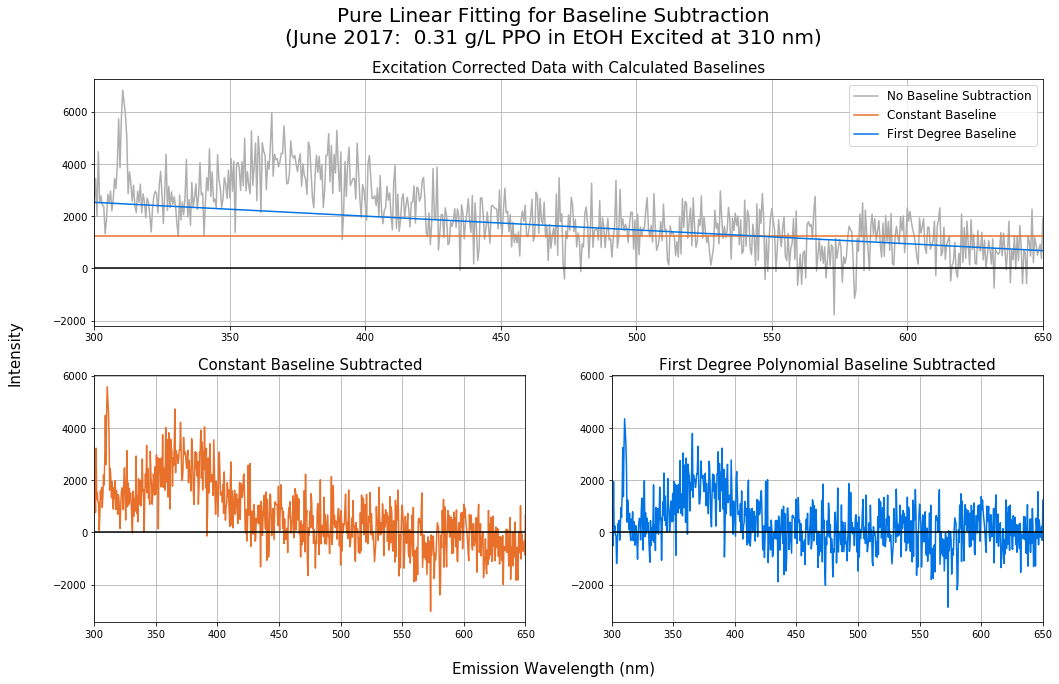

In [2]:
path = "Noah/Integrating Sphere Tests for PPO Contamination/"
test_data = PTIData(path + "EmScan_IS_0x31gperL_PPOinETOH_ex310_em300-650_2sec_20170622_noemcorr.txt")

raw_or_corrected = 'cor' # Excitation correction
wavelength_ranges = [[440,650]]

param0 = linear_fit(test_data, 0, [[300,305], [450,650]])
param1 = linear_fit(test_data, 1, [[300,305], [450,650]])

const_fit_data = param0[0] * test_data.wavelengths + param0[1]
first_fit_data = param1[0] * test_data.wavelengths + param1[1]

const_fit_subtracted = get_linear_subtracted(test_data, 0, [[300,305], [450,650]])
first_fit_subtracted = get_linear_subtracted(test_data, 1, [[300,305], [450,650]])

fig = plt.figure(figsize=(17,10))
fig.suptitle("Pure Linear Fitting for Baseline Subtraction\n"+
             "(June 2017:  0.31 g/L PPO in EtOH Excited at 310 nm)",fontsize=20)
fig.text(0.5, 0.06, 'Emission Wavelength (nm)', ha='center', va='center',fontsize=15)
fig.text(0.06, 0.5, 'Intensity', ha='center', va='center', rotation='vertical',fontsize=15)

ax1 = plt.subplot2grid((2, 2), (0, 0), colspan=2)
ax2 = plt.subplot2grid((2, 2), (1, 0))
ax3 = plt.subplot2grid((2, 2), (1, 1), sharey=ax2)

ax1.plot(test_data.wavelengths, test_data.cor_data,'#afafaf')
ax1.plot(test_data.wavelengths, const_fit_data,'#e8702a')
ax1.plot(test_data.wavelengths, first_fit_data,'#0073e5')
ax1.plot(test_data.wavelengths, 0*test_data.wavelengths,'k')
ax1.set_title("Excitation Corrected Data with Calculated Baselines", fontsize=15)
ax1.legend(['No Baseline Subtraction', "Constant Baseline", "First Degree Baseline"], fontsize=12)

ax2.plot(test_data.wavelengths, const_fit_subtracted,'#e8702a')
ax2.plot(test_data.wavelengths, 0*test_data.wavelengths,'k')
ax2.set_xlim([test_data.wavelengths[0], test_data.wavelengths[-1]])
ax2.set_title("Constant Baseline Subtracted", fontsize=15)

ax3.plot(test_data.wavelengths, first_fit_subtracted,'#0073e5')
ax3.plot(test_data.wavelengths, 0*test_data.wavelengths,'k')
ax3.set_xlim([test_data.wavelengths[0], test_data.wavelengths[-1]])
ax3.set_title("First Degree Polynomial Baseline Subtracted", fontsize=15)

for ax in [ax1, ax2,ax3]:
    ax.set_xlim([300, 650])
    ax.grid()
    
plt.show()

PTI/SpectraFitting.py:41: RuntimeWarning: overflow encountered in exp
  s_x = a * numpy.exp(-b*numpy.square(x-c))  + d*x + f


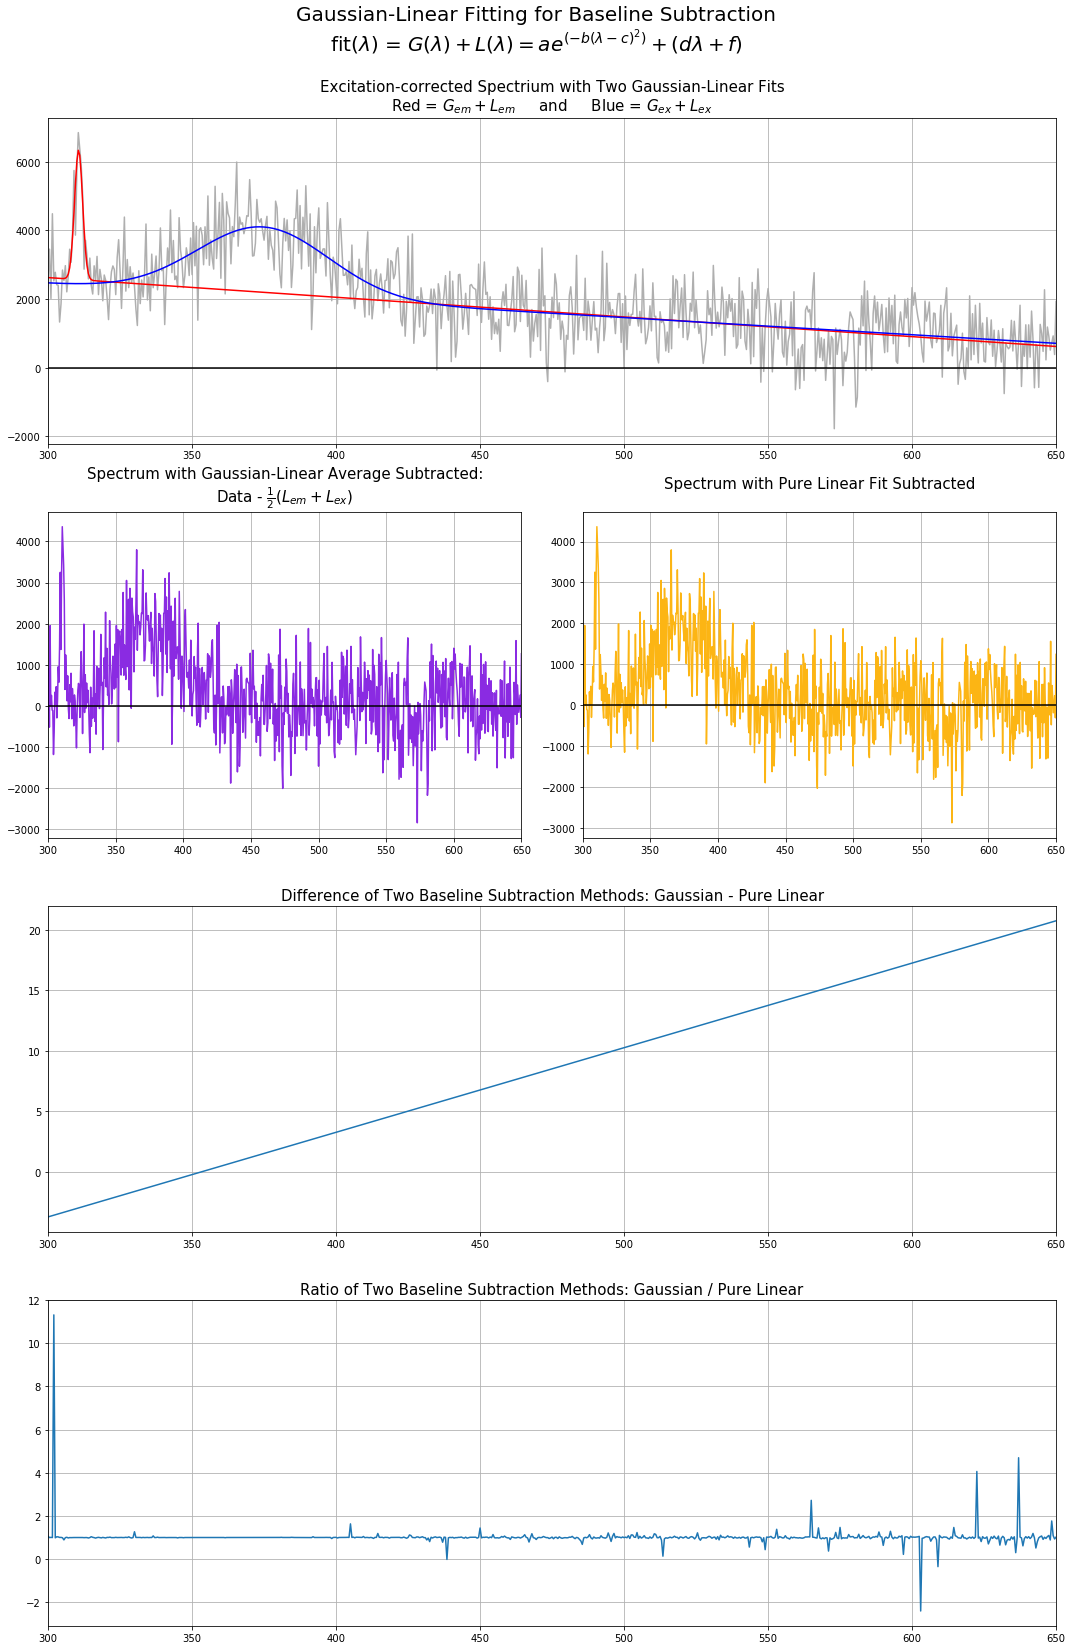

In [3]:
path = "Noah/Integrating Sphere Tests for PPO Contamination/"
test_data = PTIData(path + "EmScan_IS_0x31gperL_PPOinETOH_ex310_em300-650_2sec_20170622_noemcorr.txt")


# Get one G-L fit for the excitation peak and another for the emission peak
peak = np.max(test_data.cor_data)
ex_params = gaussian_linear_fit(test_data, [[300,320], [450,600]], (peak,1.0,310,3,1))[0]
em_params = gaussian_linear_fit(test_data, [[330,600]],(2.0,1.0,360,3,1))[0]

ex_fit = get_gaussian_linear(test_data.wavelengths, ex_params[0],ex_params[1],ex_params[2],ex_params[3],ex_params[4])
em_fit = get_gaussian_linear(test_data.wavelengths, em_params[0],em_params[1],em_params[2],em_params[3],em_params[4])

avg_linear_slope = (ex_params[3] + em_params[3]) / 2.0
avg_linear_incpt = (ex_params[4] + em_params[4]) / 2.0

# Average the two linear portions of the G-L fits to get a baseline estimate
avg_linear_baseline = avg_linear_slope*test_data.wavelengths + avg_linear_incpt
gaussian_baseline_subtracted = test_data.cor_data - avg_linear_baseline

# Calculate the purely-linear fit
linear_subtracted = get_linear_subtracted(test_data, 1, [[300,305], [450,650]])

# Compare the two fits
diff_of_fits = gaussian_baseline_subtracted - linear_subtracted
ratio_of_fits = gaussian_baseline_subtracted / linear_subtracted


fig = plt.figure(figsize=(15,22))
fig.suptitle("Gaussian-Linear Fitting for Baseline Subtraction\n"+
             r"fit$(\lambda)$ = $G(\lambda)+L(\lambda) = ae^{(-b(\lambda-c)^2)}+(d\lambda+f)$",
             y=1.04, fontsize = 20)

ax1 = plt.subplot2grid((4, 2), (0, 0), colspan=2)
ax2 = plt.subplot2grid((4, 2), (1, 0))
ax3 = plt.subplot2grid((4, 2), (1, 1))
ax4 = plt.subplot2grid((4, 2), (2, 0), colspan=2)
ax5 = plt.subplot2grid((4, 2), (3, 0), colspan=2)


ax1.plot(test_data.wavelengths,test_data.cor_data,'#afafaf')
ax1.plot(test_data.wavelengths,ex_fit ,'r')
ax1.plot(test_data.wavelengths,em_fit,'b')
ax1.plot(test_data.wavelengths,0*test_data.wavelengths,'k')
ax1.set_title("Excitation-corrected Spectrium with Two Gaussian-Linear Fits\n"+
              "Red = $G_{em} + L_{em}$     and     Blue = $G_{ex} + L_{ex}$",
              fontsize = 15)


ax2.plot(test_data.wavelengths,gaussian_baseline_subtracted,'#8A2BE2')
ax2.plot(test_data.wavelengths,0*test_data.wavelengths,'k')
ax2.set_title("Spectrum with Gaussian-Linear Average Subtracted:\n"+r"Data - $\frac{1}{2}(L_{em} + L_{ex})$",
              fontsize = 15)

ax3.plot(test_data.wavelengths, linear_subtracted,'#FCB514')
ax3.plot(test_data.wavelengths,0*test_data.wavelengths,'k')
ax3.set_title("Spectrum with Pure Linear Fit Subtracted\n",
              fontsize = 15)

ax4.plot(test_data.wavelengths, diff_of_fits)
ax4.set_title("Difference of Two Baseline Subtraction Methods: Gaussian - Pure Linear",
              fontsize = 15)

ax5.plot(test_data.wavelengths, ratio_of_fits)
ax5.set_title("Ratio of Two Baseline Subtraction Methods: Gaussian / Pure Linear",
              fontsize = 15)


for ax in [ax1,ax2,ax3,ax4,ax5]:  
    ax.grid()
    ax.set_xlim([300,650])
plt.tight_layout()
plt.show()

In the end, the two methods produced nearly identical results. The difference between the two was small. The Gaussian fitting has an advantage over the tail-end fit, however, because the process of obtaining the linear portion $L(\lambda)$ gives one the fit for the excitation/emission peak. 